In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cwt, morlet2
from scipy.stats import wilcoxon, chisquare
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

In [2]:
print("="*80)
print("ESTROUS CYCLE DETECTION VIA ULTRADIAN POWER ANALYSIS")
print("="*80)

ESTROUS CYCLE DETECTION VIA ULTRADIAN POWER ANALYSIS


In [3]:
print("\n" + "="*80)
print("SECTION 1: DEFINING WAVELET FUNCTIONS")
print("="*80)


SECTION 1: DEFINING WAVELET FUNCTIONS


In [4]:
def compute_wavelet_transform(data, periods_minutes=None, w=5):
    """
    Compute continuous wavelet transform using Morlet wavelet.
    
    Parameters:
    -----------
    data : 1D array - time series (1-min resolution)
    periods_minutes : array - periods to analyze (in minutes)
    w : int - Morlet wavelet parameter
    
    Returns:
    --------
    power : 2D array - (n_periods, n_timepoints)
    periods : array - periods analyzed (in minutes)
    """
    # Handle NaNs
    data = pd.Series(data).interpolate().bfill().ffill().fillna(0).values
    
    if periods_minutes is None:
        periods_minutes = np.logspace(np.log10(60), np.log10(39*60), 50)
    
    fs = 1  # 1 sample per minute
    scales = periods_minutes * fs * w / (2 * np.pi)
    
    coeffs = cwt(data, morlet2, scales, w=w)
    power = np.abs(coeffs)**2
    
    return power, periods_minutes

In [5]:
def extract_band_power(power, periods_minutes, band_hours):
    """
    Extract MAX power in a frequency band (per Smarr's methods).
    """
    periods_hours = periods_minutes / 60
    band_mask = (periods_hours >= band_hours[0]) & (periods_hours <= band_hours[1])
    
    if not np.any(band_mask):
        return np.zeros(power.shape[1])
    
    band_power = np.max(power[band_mask, :], axis=0)
    return band_power

In [6]:
PERIODS_MINUTES = np.logspace(np.log10(60), np.log10(39*60), 50)
PERIODS_HOURS = PERIODS_MINUTES / 60
MINUTES_PER_DAY = 1440


In [7]:
print("Wavelet functions defined.")
print(f"  Period range: {PERIODS_HOURS.min():.1f}h to {PERIODS_HOURS.max():.1f}h")
print(f"  Ultradian band: 1-3 hours")
print(f"  Circadian band: 23-25 hours")


Wavelet functions defined.
  Period range: 1.0h to 39.0h
  Ultradian band: 1-3 hours
  Circadian band: 23-25 hours


In [8]:
print("\n" + "="*80)
print("SECTION 2: LOADING SMARR 2017 DATA")
print("="*80)


SECTION 2: LOADING SMARR 2017 DATA


In [9]:
df_smarr = pd.read_csv('mice data.xlsx - FemAct (1).csv')

female_cols = [col for col in df_smarr.columns if col.startswith('fem')]
female_data = df_smarr[female_cols].values.T  # (n_females, n_timepoints)

n_females, n_timepoints = female_data.shape

In [10]:
print(f"""
SMARR 2017 DATASET:
  N females: {n_females}
  Timepoints: {n_timepoints} minutes ({n_timepoints/MINUTES_PER_DAY:.1f} days)
  Resolution: 1 minute
  Light cycle: t=0 = Lights OFF
  Estrus: Day 1 (ground truth from CBT plateau detection)
""")


SMARR 2017 DATASET:
  N females: 14
  Timepoints: 11520 minutes (8.0 days)
  Resolution: 1 minute
  Light cycle: t=0 = Lights OFF
  Estrus: Day 1 (ground truth from CBT plateau detection)



In [11]:
print("\n" + "="*80)
print("SECTION 3: LOADING MORPH2REP DATA")
print("="*80)


SECTION 3: LOADING MORPH2REP DATA


In [17]:
# =============================================================================
# LOAD MORPH2REP DATA USING DUCKDB
# =============================================================================
import duckdb

# S3 configuration
S3_BUCKET = "jax-envision-public-data"
STUDY_PATH = "study_1001/2025v3.3/tabular"

# Vehicle cages configuration
VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-10 06:00:00",
        "n_days": 11,
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-25 06:00:00",
        "n_days": 10,
    },
}

# Connect to DuckDB
con = duckdb.connect()

# Install and load httpfs extension for S3 access
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")
con.execute("SET s3_region='us-east-1';")

print("Loading Morph2REP data from S3 via DuckDB...")

# Load data for all vehicle cages
all_cages = VEHICLE_CAGES["Rep1"]["cages"] + VEHICLE_CAGES["Rep2"]["cages"]
cage_list = ",".join(str(c) for c in all_cages)

query = f"""
SELECT 
    time,
    animal_id,
    cage_id,
    name,
    value
FROM read_parquet('s3://{S3_BUCKET}/{STUDY_PATH}/cage_id=*/date=*/animal_aggs_short_id.parquet',
                  hive_partitioning=true)
WHERE cage_id IN ({cage_list})
  AND name = 'animal.distance_travelled'
"""

print("Executing query...")
df_morph = con.execute(query).fetchdf()

print(f"Loaded {len(df_morph):,} rows")

# Convert time to datetime
df_morph['time'] = pd.to_datetime(df_morph['time'])

# Assign replicate
def assign_replicate(cage_id):
    if cage_id in VEHICLE_CAGES["Rep1"]["cages"]:
        return "Rep1"
    elif cage_id in VEHICLE_CAGES["Rep2"]["cages"]:
        return "Rep2"
    return None

df_morph['replicate'] = df_morph['cage_id'].apply(assign_replicate)

print(f"\nData summary:")
print(f"  Rep1: {len(df_morph[df_morph['replicate']=='Rep1']):,} rows, {df_morph[df_morph['replicate']=='Rep1']['animal_id'].nunique()} animals")
print(f"  Rep2: {len(df_morph[df_morph['replicate']=='Rep2']):,} rows, {df_morph[df_morph['replicate']=='Rep2']['animal_id'].nunique()} animals")

Loading Morph2REP data from S3 via DuckDB...
Executing query...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded 23,256,705 rows

Data summary:
  Rep1: 12,144,781 rows, 10 animals
  Rep2: 11,111,924 rows, 10 animals


In [19]:
print("\n--- Loading Morph2REP Data ---")

S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-10",
        "analysis_end": "2025-01-22",
        "n_days": 12,
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-25",
        "analysis_end": "2025-02-04",
        "n_days": 10,
    },
}

def load_parquet_s3(cage_id, start_date, end_date, table_name):
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for d in dates:
        date_str = d.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{table_name}"
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            continue
    
    conn.close()
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()


--- Loading Morph2REP Data ---



--- Loading Morph2REP Locomotion Bout Data ---

Rep1:
  Cage 4918... 2,201,519 rows
  Cage 4922... 2,039,081 rows
  Cage 4923... 2,117,667 rows

Rep2:
  Cage 4928... 1,872,654 rows
  Cage 4929... 1,688,050 rows
  Cage 4934... 1,795,480 rows

Total bout rows: 11,714,451

Bout types available:
state_name
animal_bouts.social.in_proximity_other    4228593
animal_bouts.social.isolated_other        2674221
animal_bouts.active                       1340775
animal_bouts.social.proximal_all          1063945
animal_bouts.inactive                      939711
animal_bouts.social.isolated_all           621258
animal_bouts.locomotion                    457610
animal_bouts.climbing                      178953
animal_bouts.feeding                       158279
animal_bouts.inferred_sleep                 32415
animal_bouts.drinking                       18691
Name: count, dtype: int64

Locomotion bouts: 457,610
  Rep1: 246,975 bouts, 9 animals
  Rep2: 210,635 bouts, 9 animals

--- Converting to minute-

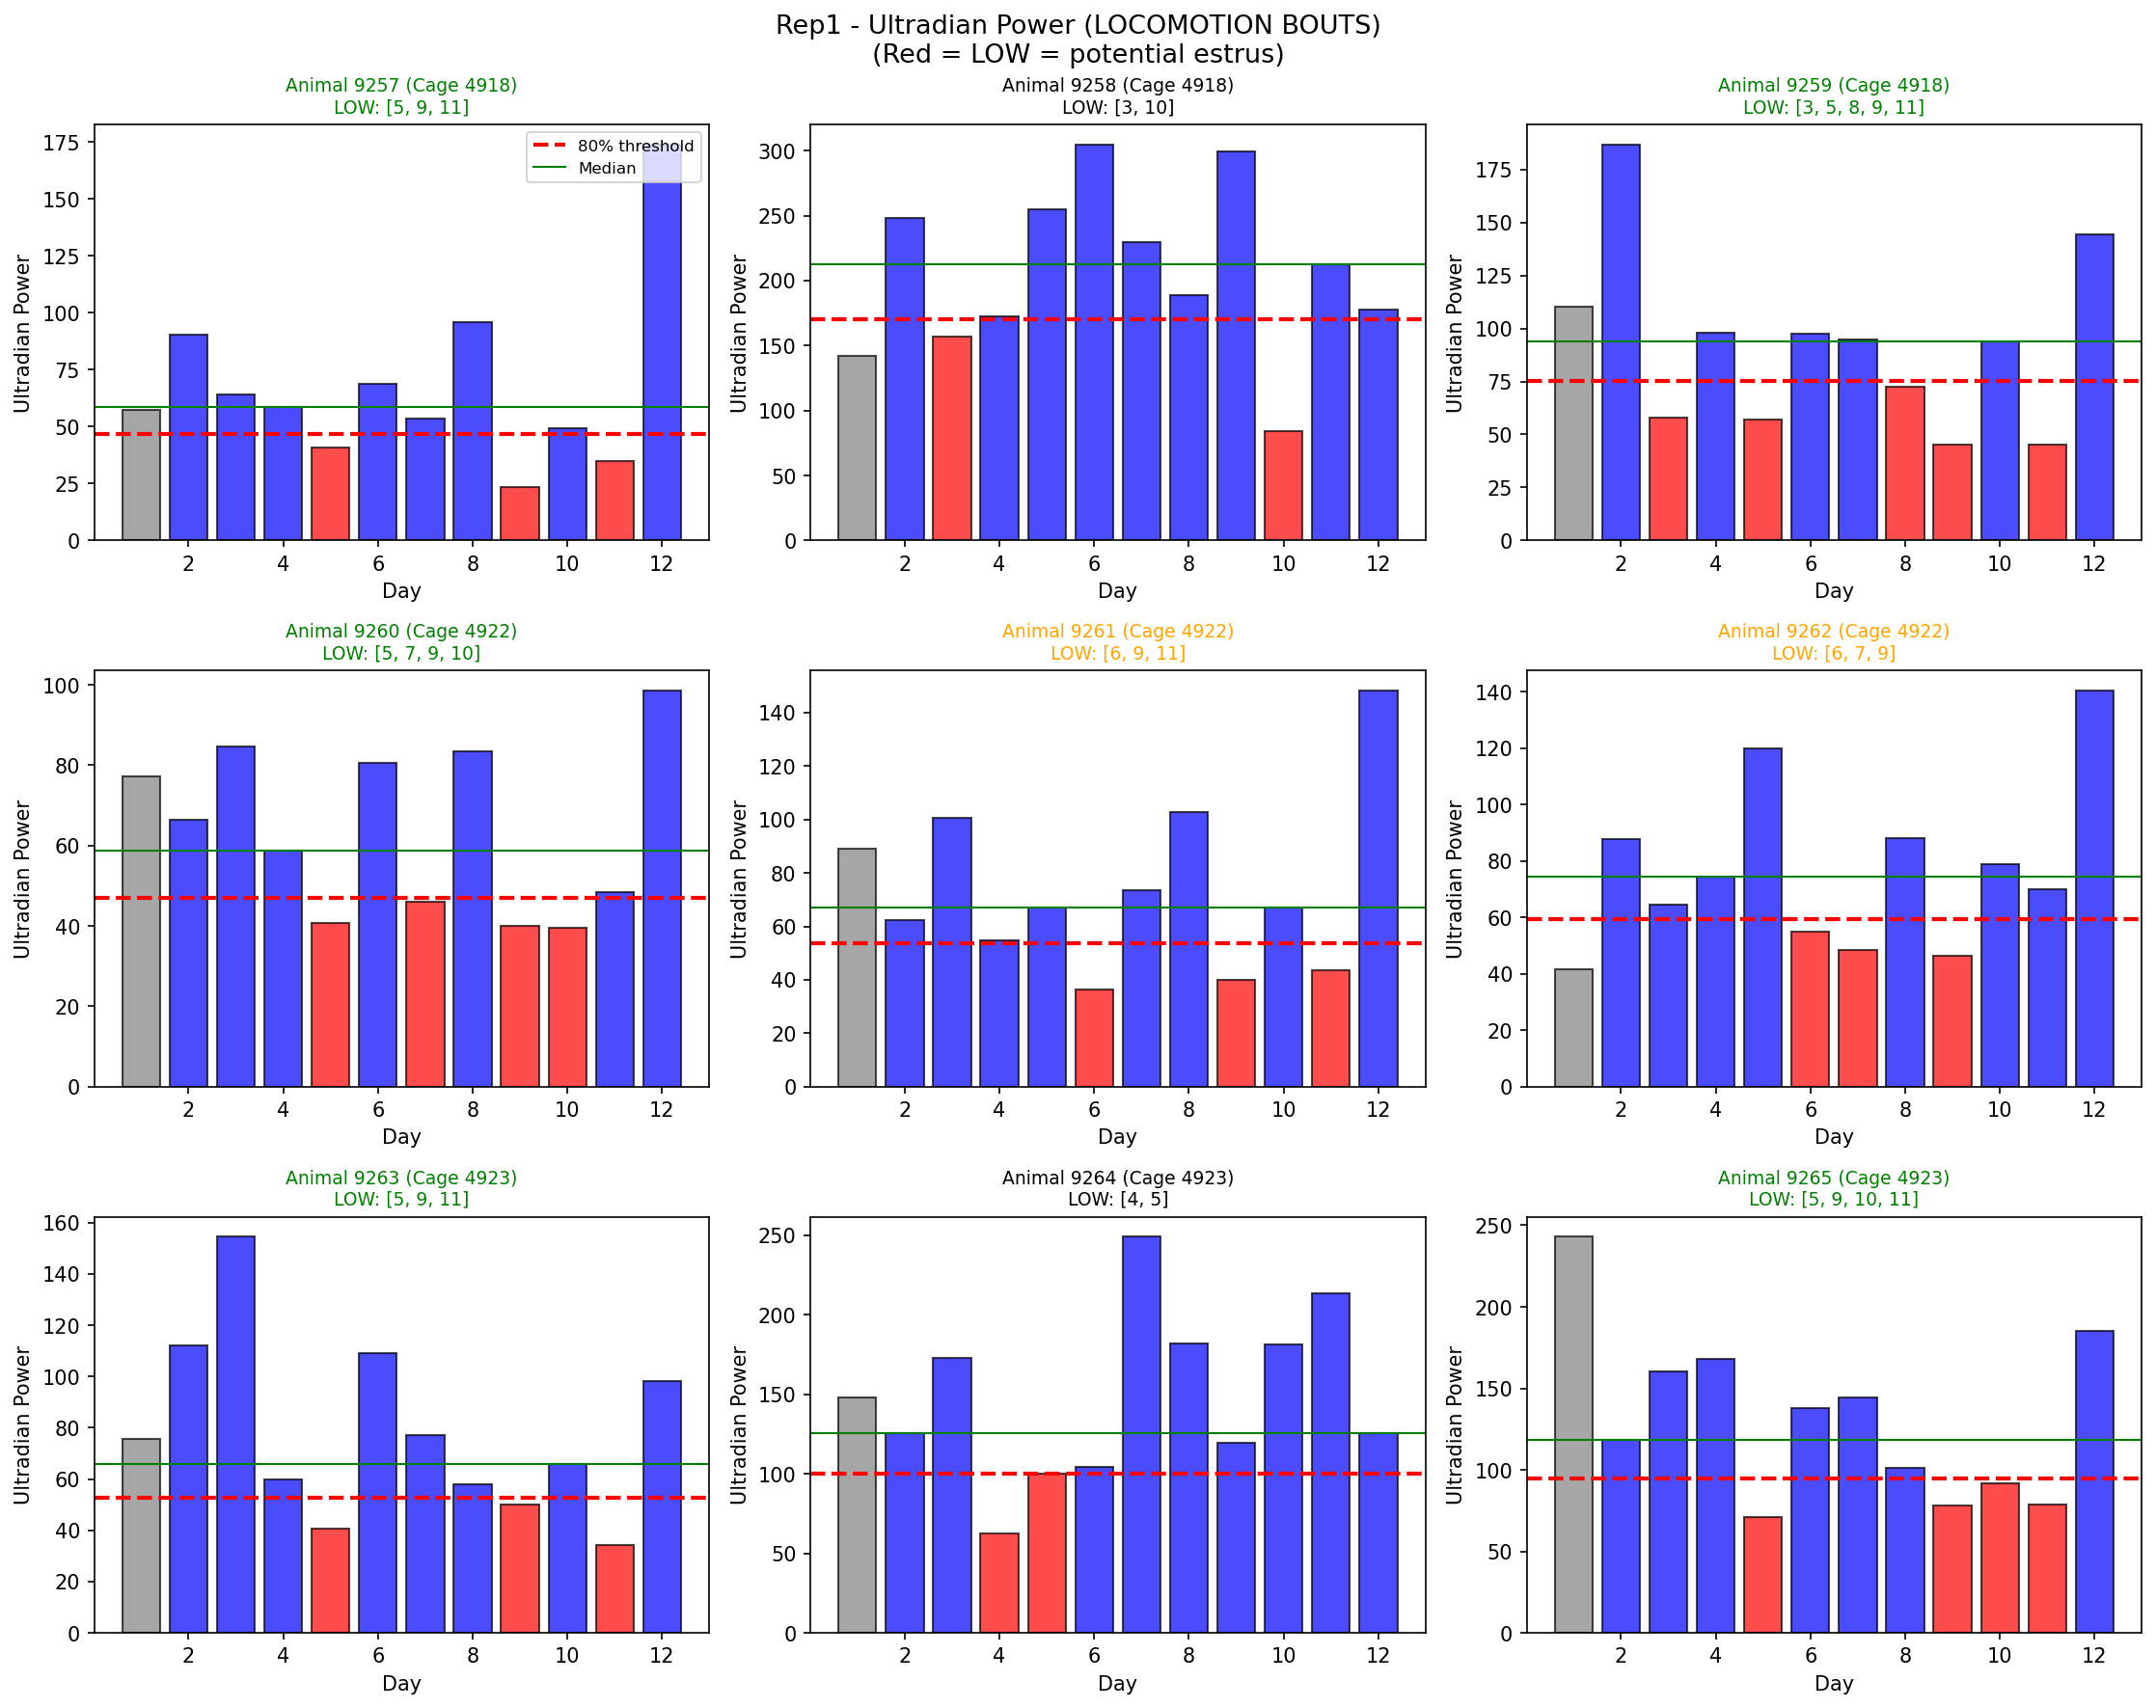


Rep2 ANALYSIS (Locomotion Bouts)
Animals: 9, Days: 10

--- Day-by-Day Ultradian Power (Locomotion) ---
Animal     Cage    D2     D3     D4     D5     D6     D7     D8     D9     D10    
----------------------------------------------------------------------------------
9266       4928    108.3  79.2   68.5   75.9   85.6   81.0   66.4   140.9  75.6   
9267       4928    164.4  91.1   82.2   87.7   48.0   41.4   51.7   139.9  111.3  
9268       4928    100.9  132.2  72.2   69.7   57.0   40.4   33.4   86.6   53.3   
9269       4929    90.7   157.0  89.6   45.6   82.8   70.4   46.6   48.6   11.6   
9270       4929    90.3   173.3  86.4   55.3   76.6   59.6   46.4   71.7   10.9   
9271       4929    74.3   121.0  66.3   53.9   55.0   42.9   44.7   46.9   8.3    
9272       4934    130.0  132.9  77.9   42.3   69.1   43.9   36.7   64.3   90.7   
9273       4934    77.4   92.0   96.8   62.8   80.9   80.0   43.2   72.2   98.1   
9274       4934    92.5   78.4   102.2  101.2  105.2  95.3   92.4 

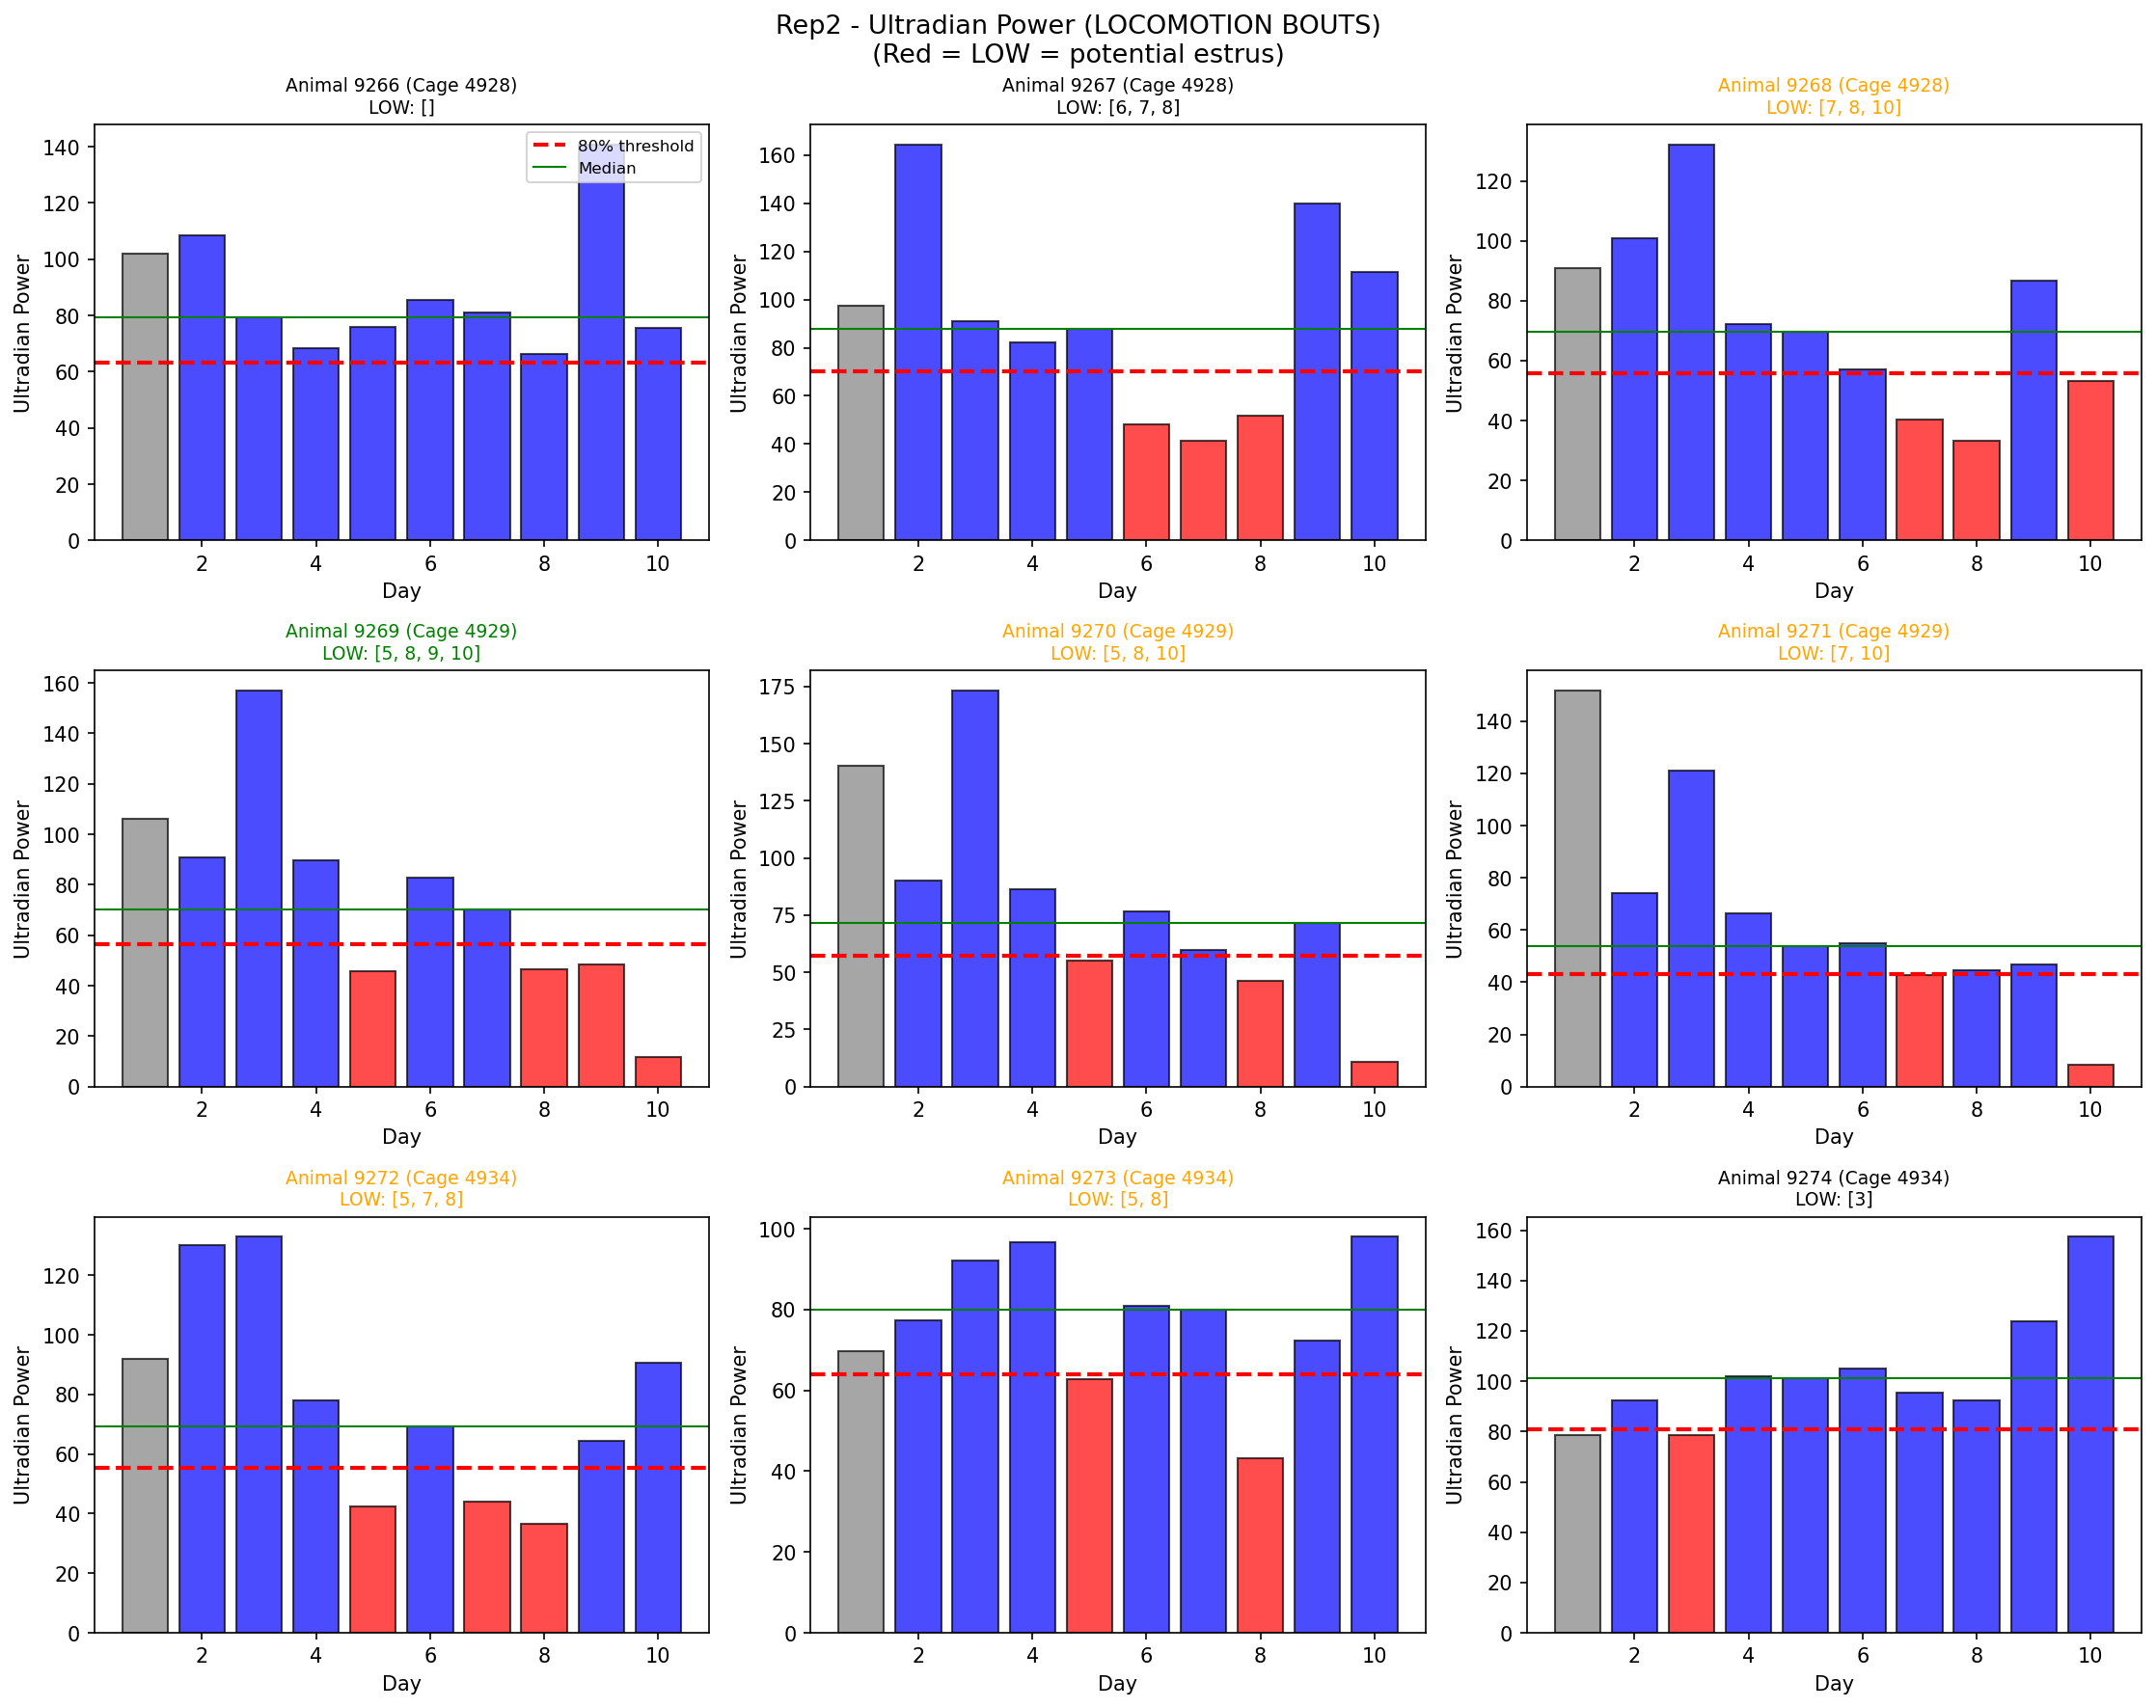

In [23]:
# =============================================================================
# LOAD MORPH2REP DATA - LOCOMOTION BOUTS
# =============================================================================
print("\n--- Loading Morph2REP Locomotion Bout Data ---")

# Load animal_bouts.parquet instead of animal_aggs_short_id.parquet
all_bouts = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bouts.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_bouts.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print(f"\nTotal bout rows: {len(df_bouts):,}")

# Check available bout types
print(f"\nBout types available:")
print(df_bouts['state_name'].value_counts())

# Filter for locomotion bouts
df_loco = df_bouts[df_bouts['state_name'] == 'animal_bouts.locomotion'].copy()
df_loco['start_time'] = pd.to_datetime(df_loco['start_time'])

print(f"\nLocomotion bouts: {len(df_loco):,}")
for rep in ['Rep1', 'Rep2']:
    rep_df = df_loco[df_loco['replicate'] == rep]
    print(f"  {rep}: {len(rep_df):,} bouts, {rep_df['animal_id'].nunique()} animals")

# =============================================================================
# CONVERT BOUTS TO MINUTE-LEVEL COUNTS (like Smarr's activity counts)
# =============================================================================
print("\n--- Converting to minute-level bout counts ---")

def bouts_to_minute_counts(bout_df, start_time, n_minutes):
    """
    Convert bout data to minute-level counts.
    For each minute, count how many bouts started in that minute.
    """
    bout_df = bout_df.copy()
    bout_df['minutes_from_start'] = (bout_df['start_time'] - start_time).dt.total_seconds() / 60
    bout_df = bout_df[(bout_df['minutes_from_start'] >= 0) & (bout_df['minutes_from_start'] < n_minutes)]
    bout_df['minute_bin'] = bout_df['minutes_from_start'].astype(int)
    
    # Count bouts per minute
    counts = bout_df.groupby('minute_bin').size()
    
    # Create full time series
    full_series = pd.Series(index=range(n_minutes), dtype=float).fillna(0)
    full_series.update(counts)
    
    return full_series.values

# =============================================================================
# MORPH2REP WAVELET ANALYSIS WITH LOCOMOTION BOUTS
# =============================================================================
print("\n" + "="*80)
print("MORPH2REP WAVELET ANALYSIS - LOCOMOTION BOUTS")
print("="*80)

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{'='*60}")
    print(f"{rep} ANALYSIS (Locomotion Bouts)")
    print(f"{'='*60}")
    
    # Shift start to 6PM (lights off) to match Smarr
    original_start = pd.to_datetime(cfg['analysis_start'] + " 06:00:00")
    shifted_start = original_start + pd.Timedelta(hours=12)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    
    animals = sorted([a for a in rep_df['animal_id'].unique() if a != 0])
    max_minutes = cfg['n_days'] * MINUTES_PER_DAY
    
    print(f"Animals: {len(animals)}, Days: {cfg['n_days']}")
    
    # Compute wavelet for each animal
    animal_results = []
    
    for animal_id in animals:
        animal_df = rep_df[rep_df['animal_id'] == animal_id].copy()
        cage_id = animal_df['cage_id'].iloc[0]
        
        # Convert bouts to minute counts
        animal_ts = bouts_to_minute_counts(animal_df, shifted_start, max_minutes)
        
        n_days_actual = len(animal_ts) / MINUTES_PER_DAY
        if n_days_actual < 6:
            continue
        
        # Compute wavelet
        power, _ = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
        ultradian = extract_band_power(power, PERIODS_MINUTES, (1, 3))
        
        # Day-by-day power
        n_complete_days = int(len(ultradian) / MINUTES_PER_DAY)
        day_powers = []
        for day in range(1, n_complete_days + 1):
            day_start = (day - 1) * MINUTES_PER_DAY
            day_end = day * MINUTES_PER_DAY
            if day_end <= len(ultradian):
                day_powers.append(np.nanmean(ultradian[day_start:day_end]))
            else:
                day_powers.append(np.nan)
        
        animal_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'day_powers': day_powers,
            'n_days': n_complete_days
        })
    
    # -------------------------------------------------------------------------
    # DAY-BY-DAY TABLE
    # -------------------------------------------------------------------------
    print(f"\n--- Day-by-Day Ultradian Power (Locomotion) ---")
    
    max_days = max(r['n_days'] for r in animal_results)
    
    header = f"{'Animal':<10} {'Cage':<8}"
    for d in range(2, max_days + 1):
        header += f"{'D'+str(d):<7}"
    print(header)
    print("-" * len(header))
    
    for r in animal_results:
        row = f"{r['animal_id']:<10} {r['cage_id']:<8}"
        for d in range(2, max_days + 1):
            idx = d - 1
            if idx < len(r['day_powers']):
                val = r['day_powers'][idx]
                row += f"{val:<7.1f}" if not np.isnan(val) else f"{'N/A':<7}"
            else:
                row += f"{'---':<7}"
        print(row)
    
    # -------------------------------------------------------------------------
    # LOW DAY DETECTION
    # -------------------------------------------------------------------------
    print(f"\n--- LOW Days Detection (<80% median, excl Day 1) ---")
    
    threshold_pct = 0.80
    
    print(f"{'Animal':<10} {'Cage':<8} {'LOW days':<25} {'Spacings':<20} {'4-day cycle?'}")
    print("-"*90)
    
    cycle_results = []
    
    for r in animal_results:
        animal_id = r['animal_id']
        cage_id = r['cage_id']
        day_powers = r['day_powers']
        
        valid_powers = [p for i, p in enumerate(day_powers) if i > 0 and not np.isnan(p)]
        if not valid_powers:
            continue
        
        median_power = np.median(valid_powers)
        threshold = median_power * threshold_pct
        
        low_days = []
        for day in range(2, len(day_powers) + 1):
            idx = day - 1
            if not np.isnan(day_powers[idx]) and day_powers[idx] < threshold:
                low_days.append(day)
        
        spacings = [low_days[i] - low_days[i-1] for i in range(1, len(low_days))]
        
        has_exact_4 = any(d2 - d1 == 4 for d1 in low_days for d2 in low_days if d2 > d1)
        has_approx_4 = any(3 <= d2 - d1 <= 5 for d1 in low_days for d2 in low_days if d2 > d1)
        
        if len(low_days) >= 2 and has_exact_4:
            assessment = "✓ STRONG"
        elif len(low_days) >= 2 and has_approx_4:
            assessment = "~ MODERATE"
        elif len(low_days) >= 2:
            assessment = "? IRREGULAR"
        else:
            assessment = "✗ INSUFFICIENT"
        
        cycle_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'low_days': low_days,
            'spacings': spacings,
            'has_4day': has_exact_4,
            'assessment': assessment
        })
        
        print(f"{animal_id:<10} {cage_id:<8} {str(low_days):<25} {str(spacings):<20} {assessment}")
    
    # Summary
    n_strong = sum(1 for r in cycle_results if '✓' in r['assessment'])
    n_moderate = sum(1 for r in cycle_results if '~' in r['assessment'])
    n_total = len(cycle_results)
    
    print("-"*90)
    print(f"Strong 4-day cycling: {n_strong}/{n_total}")
    print(f"Moderate evidence: {n_moderate}/{n_total}")
    
    # -------------------------------------------------------------------------
    # PHASE CONSISTENCY CHECK
    # -------------------------------------------------------------------------
    print(f"\n--- Phase Consistency Check ---")
    
    all_low_days = []
    for r in cycle_results:
        all_low_days.extend(r['low_days'])
    
    phases = [(d - 1) % 4 for d in all_low_days]
    phase_counts = Counter(phases)
    
    print(f"Phase 0 (Days 1,5,9...): {phase_counts.get(0, 0)}")
    print(f"Phase 1 (Days 2,6,10...): {phase_counts.get(1, 0)}")
    print(f"Phase 2 (Days 3,7,11...): {phase_counts.get(2, 0)}")
    print(f"Phase 3 (Days 4,8,12...): {phase_counts.get(3, 0)}")
    
    if sum(phase_counts.values()) >= 4:
        observed = [phase_counts.get(i, 0) for i in range(4)]
        expected = [len(all_low_days) / 4] * 4
        stat, p_chi = chisquare(observed, expected)
        print(f"\nChi-square test: χ²={stat:.2f}, p={p_chi:.4f}")
        if p_chi < 0.05:
            dominant = max(phase_counts, key=phase_counts.get)
            print(f"→ Significant clustering at Phase {dominant}")
        else:
            print(f"→ No significant clustering")
    
    # -------------------------------------------------------------------------
    # VISUALIZE
    # -------------------------------------------------------------------------
    n_animals = len(animal_results)
    n_cols = 3
    n_rows = (n_animals + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for idx, r in enumerate(animal_results):
        ax = axes[idx]
        day_powers = r['day_powers']
        days = list(range(1, len(day_powers) + 1))
        
        valid_powers = [p for i, p in enumerate(day_powers) if i > 0 and not np.isnan(p)]
        median_power = np.median(valid_powers) if valid_powers else 0
        threshold = median_power * 0.80
        
        colors = []
        for i, p in enumerate(day_powers):
            if i == 0:
                colors.append('gray')
            elif np.isnan(p):
                colors.append('white')
            elif p < threshold:
                colors.append('red')
            else:
                colors.append('blue')
        
        ax.bar(days, day_powers, color=colors, edgecolor='black', alpha=0.7)
        ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='80% threshold')
        ax.axhline(y=median_power, color='green', linestyle='-', linewidth=1, label='Median')
        
        result = next((c for c in cycle_results if c['animal_id'] == r['animal_id']), None)
        if result:
            title_color = 'green' if '✓' in result['assessment'] else 'orange' if '~' in result['assessment'] else 'black'
            ax.set_title(f"Animal {r['animal_id']} (Cage {r['cage_id']})\nLOW: {result['low_days']}", 
                        fontsize=9, color=title_color)
        else:
            ax.set_title(f"Animal {r['animal_id']} (Cage {r['cage_id']})", fontsize=9)
        
        ax.set_xlabel('Day')
        ax.set_ylabel('Ultradian Power')
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8)
    
    for idx in range(len(animal_results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{rep} - Ultradian Power (LOCOMOTION BOUTS)\n(Red = LOW = potential estrus)', fontsize=13)
    plt.tight_layout()
    plt.savefig(f'morph2rep_{rep}_locomotion_wavelet.png', dpi=150, bbox_inches='tight')
    plt.show()

In [22]:
# Check available bout types
print(f"\nBout types available:")
print(df_bouts['state_name'].value_counts())

# Filter for locomotion bouts
df_loco = df_bouts[df_bouts['state_name'] == 'animal_bouts.locomotion'].copy()
df_loco['start_time'] = pd.to_datetime(df_loco['start_time'])

print(f"\nLocomotion bouts: {len(df_loco):,}")

# If no locomotion, check what's available
if len(df_loco) == 0:
    print("No 'animal_bouts.locomotion' found. Available states:")
    print(df_bouts['state_name'].unique())


Bout types available:
state_name
animal_bouts.social.in_proximity_other    4228593
animal_bouts.social.isolated_other        2674221
animal_bouts.active                       1340775
animal_bouts.social.proximal_all          1063945
animal_bouts.inactive                      939711
animal_bouts.social.isolated_all           621258
animal_bouts.locomotion                    457610
animal_bouts.climbing                      178953
animal_bouts.feeding                       158279
animal_bouts.inferred_sleep                 32415
animal_bouts.drinking                       18691
Name: count, dtype: int64

Locomotion bouts: 457,610
